In [1]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import cv2

%matplotlib widget

In [2]:
# make the plots bigger
plt.rcParams["figure.figsize"] = (10,10)

# Line detection

Let's look at one last function from OpenCV that I think could prove useful in trying to fit lines on the image. This time it's actually an line detection algorithm!         
Line detecion algorithms 
You can find out details about how it works here: https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html

The basic idea is that we transform our image pixel coordinates into a space in which it is easier to find those pixels that lie on a line (i.e. are colinear).        
With Hough transform (read as Hoff, he was a dutch particle physicist looking for trails in cloud chambers I beleive) we convert all pixels that are above some treshold value (i.e. bright enough) into polar coordinates. 

When we convert the coordinates $(x_0, y_0) \rightarrow (r, \theta)$ each pixel effectively becomes a sine or a cosine function. The pixels that lie on the same line will have their cosine function intersect at some $(r_x, \theta_x)$ point. Converting that intersection $(r_c, \theta_c)$ back to Cartesian coordinates $(x_c, y_c)$  gives us two points $(x_0, y_0)$ and $(x_c, y_c)$ which define the line that connects them. When we convert all bright enough pixels to this space, and find the points in which most of their cosines intersect, we will find a line that passes through the maximal number of pixels in our image. 

This works amazingly well, but it also suffers from a bit of a catch-22. Let's see this in action.

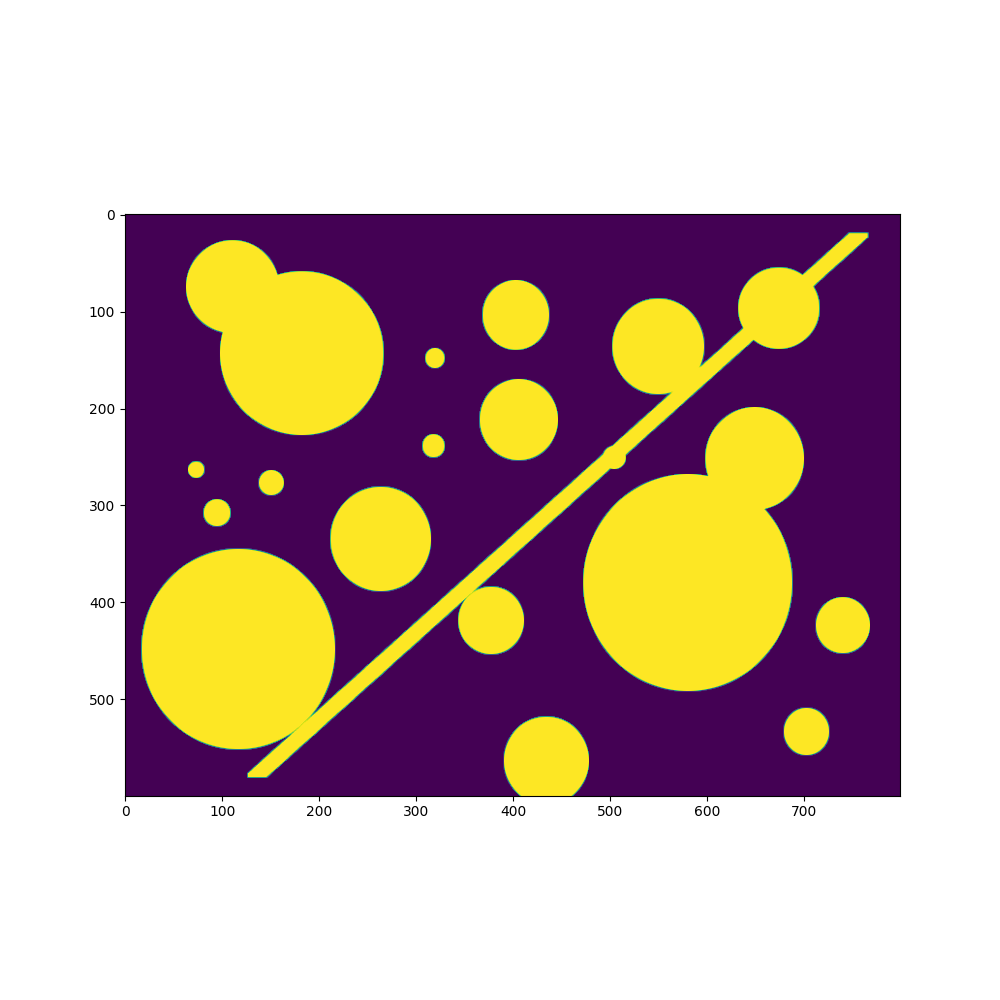

In [3]:
img = cv2.imread("images/hough_lines1.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(img)

lines = cv2.HoughLines(
    image=img,
    rho=1,
    theta=np.pi/180, 
    threshold=0
)

In [4]:
def draw_lines(lines, image, nlines=-1, color=(255, 255, 255), lw=2):
    """
    Draws Hough lines on a given image.
    
    Parameters
    ----------
    lines : `cv2.HoughLines`
        2D array of line parameters, line parameters are stored in [0][x] as
        tuples.
    image : `np.array`
        Image on which to draw the lines
    nlines : `int` or `slice`
        Number of top-voted for lines to draw, or a slice object corectly 
        indexing the lines array. By default draws all lines.
    color : `tuple`
        Tuple of values defining a BGR color.
    lw : `int`
        Line width.
    """
    dimx, dimy = image.shape
    # convert to color image so that you can see the lines
    draw_im = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    if isinstance(nlines, slice):
        draw = lines[nlines]
    else:
        draw = lines[:nlines]
    
    for params in draw:
        if len(params[0]) == 2:
            # this is non-probabilistic hough branch
            rho, theta = params[0]
            x0 = np.cos(theta) * rho
            y0 = np.sin(theta) * rho
            pt1 = (
                int(x0 - (dimx + dimy) * np.sin(theta)),
                int(y0 + (dimx + dimy) * np.cos(theta))
            )
            pt2 = (
                int(x0 + (dimx + dimy) * np.sin(theta)),
                int(y0 - (dimx + dimy) * np.cos(theta))
            )
            cv2.line(draw_im, pt1, pt2, color, lw)
        else:
            # this is probabilistic hough branch
            cv2.line(draw_im, (params[0, 0], params[0,1]), (params[0, 2], params[0, 3]), color, lw)
        
    return draw_im

limg = np.zeros(img.shape, dtype=np.uint8)
limg = draw_lines(lines, limg, 250)
plt.imshow(limg)

Oh no, what happend! 

Predictably, because Hough Transform votes for all pixels that are not zero it also votes for the circles. To be more precise, disks. But the diameters of disks also are lines. Therefore - we get lines fitted to the circles as well.        
Not just that, additionally we can see that for each object we seemingly fit many lines. This is not unexpected either, since we can consider each line in the image as a rectangle with the smallest possible diameter of at least 1 - then we have at least 3 lines per rectangle. One is the upper side, one is the lower side and one follows the diagonal. And also everything in between these extremes. 

So, unfortunately, using line detectors require us to clean our original image again. We can do that by tresholding, or edge detection, and then again clean up the retrieved lines so that we might find the best matching line. 

But even then, if we found a line, we in principle would not be sure how long that line would be. There is a so-called probabilisic Hough line detection algorithm that could return us the best guess of the line lengths, before we go on with some example strategies on how to clean up the image let's take a peek at what those lines look like.         
As a side note, probabilistic Hough will likely perform much better in the example image, given that it's essentially a bitmap with crystal clear edges.

Do note that the parameters for the probabilistic transform had to be adjusted for this particular image because otherwise too many lines would be returned (as in, all non-black pixels would be declared lines of length 1).

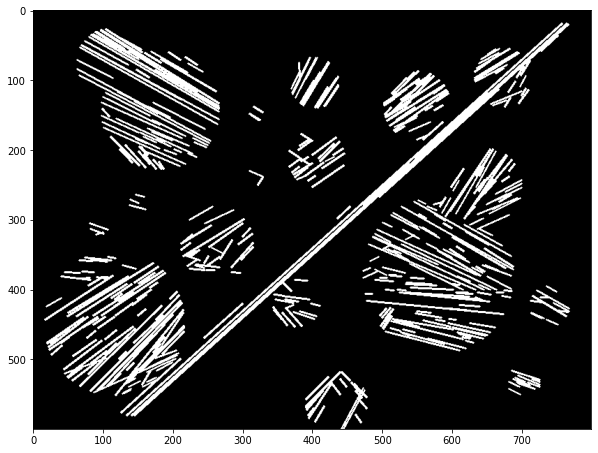

In [5]:
lines = cv2.HoughLinesP(
    image=img,
    rho=1,
    theta=np.pi/360., 
    threshold=100,
    minLineLength=10,
)

limg = np.zeros(img.shape, dtype=np.uint8)
limg = draw_lines(lines, limg, slice(0, -1, 5))
plt.imshow(limg)

Ok, with the basic invocation out of the way, what can we do about helping Hough transform detect the correct trails?

Thresholding won't help us in this case, because we already effectively have a premade bitmap. It could come in handy on real images though.

Edge detectors would at least thin out our objects which would clean up the number of psosible lines by a lot.

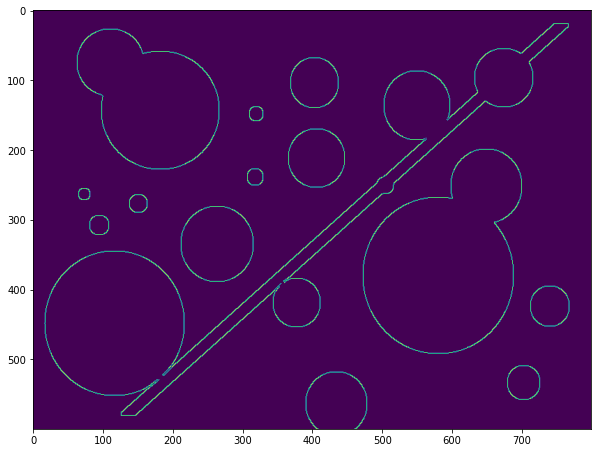

In [6]:
img = cv2.imread("images/hough_lines1.png", cv2.IMREAD_GRAYSCALE)
edges = cv2.Canny(img, 100, 200)
plt.imshow(edges)

We can also take advantage of the treshold operator to weed out lines that don't hit a lot of pixels.       
We do have to figure out a reasonable treshold for that however, how about 30% of the maximum image size?

Threshold: 300 pixels


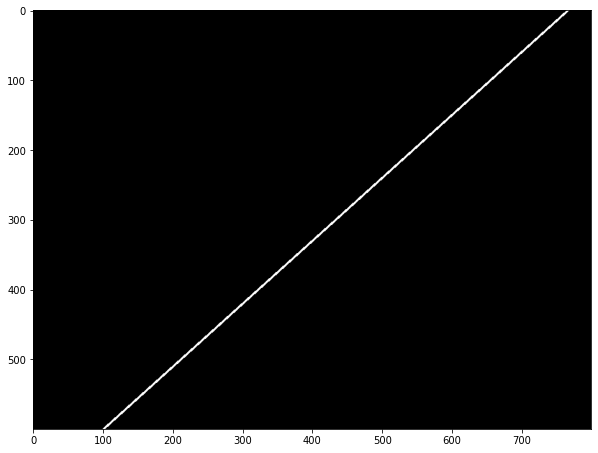

In [7]:
dimx, dimy = img.shape
diagonal = np.sqrt(dimx**2 + dimy**2)
threshold = int(0.3 * diagonal)
print(f"Threshold: {threshold} pixels")

lines = cv2.HoughLines(edges, 1, np.pi/180, threshold)

limg = np.zeros(img.shape, dtype=np.uint8)
limg = draw_lines(lines, limg)
plt.imshow(limg)

Wow, much better. Unfortunately, if we remember the extra-section in notebook `4_edge_detection` we can remember that the edge detectors are not be best when it comes to noise, and our results after applying them on an real image were not the best looking thing we made so far.                 
It does show us that the Hough transform is really sucseptible to filled in objects, but is really good at ignoring edge maps. To make this point really obvious, let's take a look at the same image as above, but one that does not use filled in circles from start. 

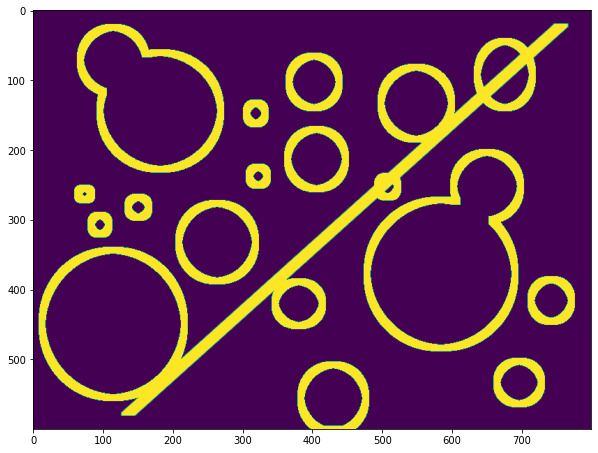

In [8]:
img2 = cv2.imread("images/hough_lines2.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(img2)

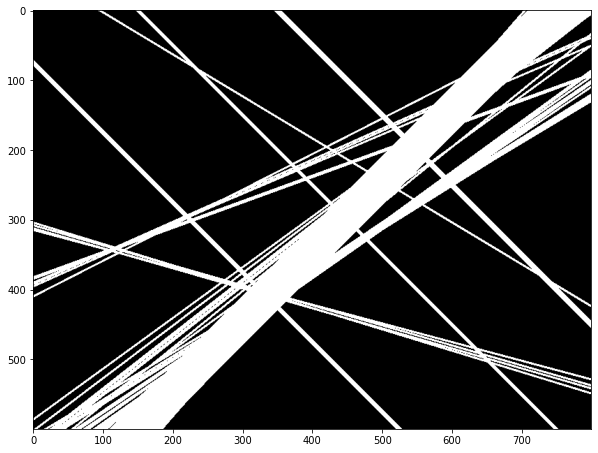

In [9]:
lines = cv2.HoughLines(img2, 1, np.pi/180, threshold)

limg = np.zeros(img2.shape, dtype=np.uint8)
limg = draw_lines(lines, limg)
plt.imshow(limg)

Not as good as processing with Canny and guessing all of the required thresholding and canny parameters just right, but pretty good! Compared to our initial attempt at just naively running Hough transform on an unprocessed bitmap image it's more than half way there already.

Obviously this only works because the whole image is as if we took a shortcut over Canny edge detection. So the question is, why even mention this? 

## Analysing real data revisited.

The reasoning is that in astronomy we can rely on source catalogs. These are large catalogs of of all detected objects (stars, galaxies, asteroids etc.) and their parameters, such as position, color, size, brightness etc. This is additional external information we can fold into our processing to ensure we delete as much additional confusing signal there is without harming the trails!        
But why even bother with doing all that when we could have gotten all the examples we did so far to work without doing that anyhow. 

To make this as clear as possible we need to revisit an real-data example we already saw in an earlier notebook (see `4_edge_detection`).             
Let's repeat some steps again. For that we need to dump code we used before into the cells below. Hopefully, by now, a lot of that code is less mystical than it was. So let's start:

In [10]:
import astropy.visualization as aviz
import astropy.io.fits as fitsio

# have you figured out what this is yet?
# a hint is in the name
def z_score_trim(image, nstd, set_to_limits=None):
    mean = image.mean()
    std = image.std()
    
    upperz = mean + nstd*std
    lowerz = mean - nstd*std
    
    if set_to_limits is None:
        upper = upperz
        lower = lowerz
    else:
        upper, lower = set_to_limits
        
    image[image > upperz] = upper
    image[image < lowerz] = lower
    
    return image

# Did you figure how this works too?
def keep_top_percent(image, keep_percent):
    hist, bars = np.histogram(image, "auto", density=True)
    cdf = np.cumsum(hist*np.diff(bars))
    cutoff = np.where(cdf > 1-keep_percent)[0][0]
    image[image < bars[cutoff]] = 0
    
    return image

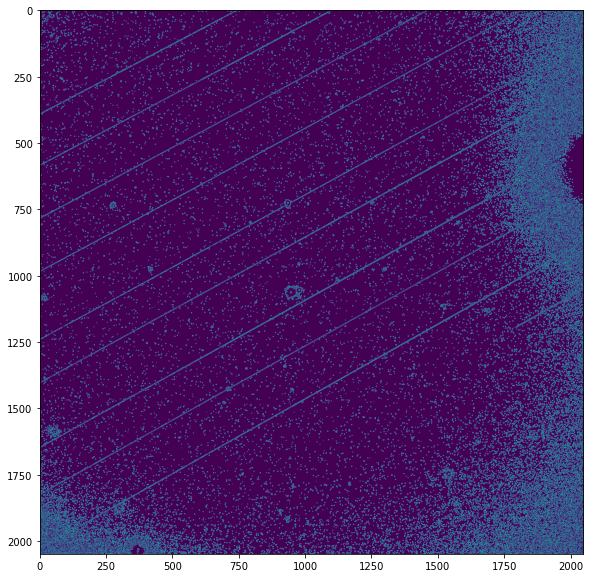

In [11]:
hdulist = fitsio.open("images/bi327715.fits")
img = hdulist[0].data

# Make a copy so we can refer back to original image if we need to
processed_image = img.copy()

processed_image = z_score_trim(processed_image, 5, (0, 0))
processed_image = z_score_trim(processed_image, 3)
processed_image = keep_top_percent(processed_image, 0.05)

# Before we re-cast the values in the processed_image it's 
# always good to standardize them and then shift them so they are
# bigger than zero, otherwise CV will kind of eat our image.
# This part is not some statistical tool, it's a workaround over CV.
processed_image = (processed_image-processed_image.mean())/processed_image.std()
processed_image -= processed_image.min()
processed_image = cv2.normalize(processed_image, processed_image, 0, 255, cv2.NORM_MINMAX)
processed_image = cv2.convertScaleAbs(processed_image)

threshold, thresholded_image = cv2.threshold(processed_image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
edges = cv2.Canny(thresholded_image, 200, 230)

plt.imshow(edges)

Threshold: 289 pixels
Found 1664 lines.


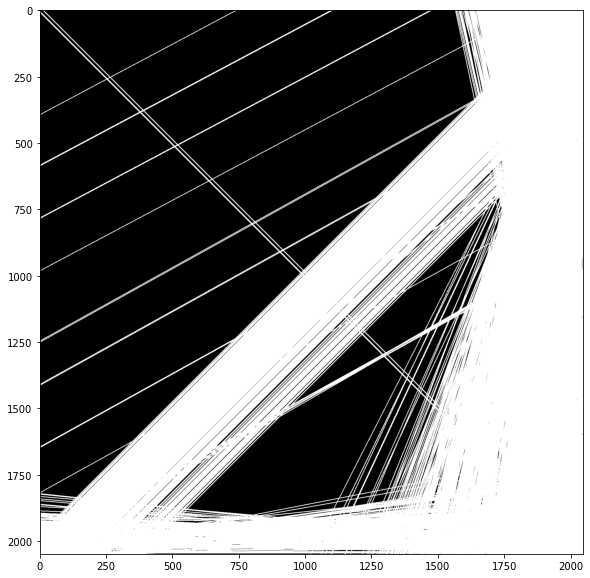

In [12]:
dimx, dimy = processed_image.shape
diagonal = np.sqrt(dimx**2 + dimy**2)
threshold = int(0.1 * diagonal)
print(f"Threshold: {threshold} pixels")

lines = cv2.HoughLines(edges, 1, np.pi/180, threshold)
print(f"Found {len(lines)} lines.")

limg = np.zeros(img.shape, dtype=np.uint8)
limg = draw_lines(lines, limg)
plt.imshow(limg)

# Conclusion

Ok, not bad, not great either. How are we supposed to tell good lines from bad ones in all that mess? Well, that's the challenge.

Couple of ideas we already saw were:
* Lines are expected to be very bright in our images -> good outlier rejection gets us really close already.
* Good outlier rejection depends on the types of objects in the image, large bright objects raise the signal mean and std which makes making a good cut on data harder --> getting rid of known objects would help
  * Getting rid of known objects would also have the effect of helping Hough line findng algorithm, as we demonstrated in this notebook
  * To really drive home the point how much removing known sources would help, I've taken the liberty to make two really large plots of our original image and our image after outlier rejection and brightness cut.         
    Nearly all of the points in the edge image (above) are actually real objects and not a bad detection by Canny algorithm.
* Perhaps the solution to the problem does not lie in removing known objects. Even without having a catalog of known objects in our images availible to us we could still rely on contours in order to describe and filter the shapes of objects.                        
  Could we somehow find our lines by relying on contours instead?
* Perhaps the real solution lies in a combination of these various approaches, where we use results from one approach to validate and confirm the results from another?  

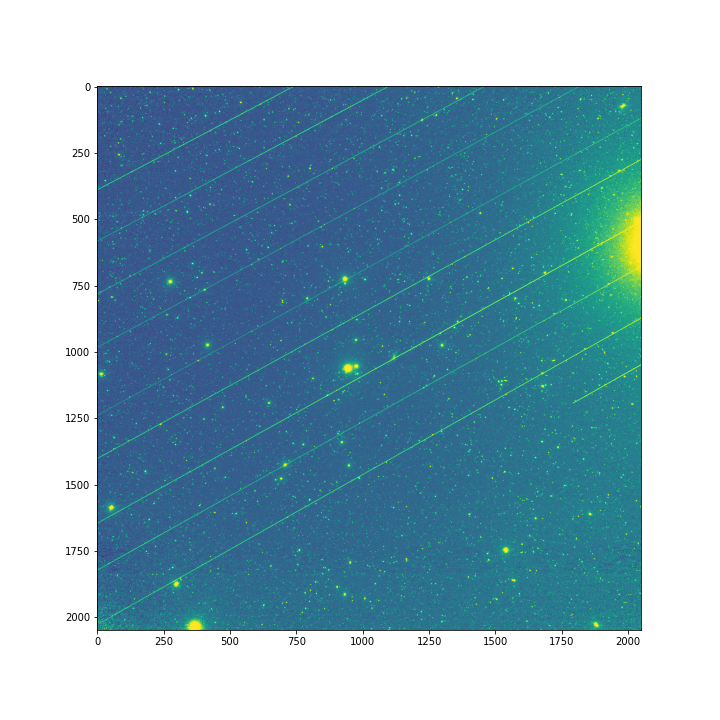

In [13]:
%matplotlib widget

from matplotlib import animation


img = cv2.imread("images/bi327715.png", cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(figsize=(10, 10))

images = [img[::-1], processed_image]
im = ax.imshow(images[0])

def init():
    im.set_data(images[0])
    return im,

def animate(i):
    im.set_data(images[i%2])
    return im,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=1000, interval=20)
plt.show()